In [53]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import matplotlib
import requests as rq
import csv
import json

# Реализация через csv-файл

## Загрузка и первоначльная обработка данных

In [48]:
# Ссылка на данные
url = "https://iss.moex.com/iss/analyticalproducts/futoi/securities.csv"

In [49]:
# Отправляем GET-запрос по указанному URL
response = rq.get(url)

# Проверяем, был ли запрос успешным (код состояния HTTP 200)
if response.status_code == 200:
    # Открываем файл для записи в бинарном режиме
    with open("securities.csv", "wb") as csv_file:
        # Записываем содержимое ответа (CSV-файла) в локальный файл
        csv_file.write(response.content)
else:
    print("Не удалось скачать файл. Код состояния HTTP:", response.status_code)

In [ ]:
# Разделяем информацию в файле
with open('securities.csv', 'r', newline='') as csv_file:
  spamreader = csv.reader(csv_file, delimiter=' ', quotechar='|')
  for row in spamreader:
    print('; '.join(row))

In [51]:
# Удаляем ненужные строк с мусором в начале и конце файла
with open('securities.csv', 'r') as csv_file:
    # Создаем объект для чтения csv файла
    reader = csv.reader(csv_file)
    # Указываем количество пропускаемых в конце строчек
    rows_to_skip = len(list(reader)) - 7
    # Переносик каретку (указатель) чтения на начало файла
    csv_file.seek(0)
    # Пропускаем первую строку
    next(reader)
    # Создаем объект для чтения csv файла снова
    reader = csv.reader(csv_file)
    # Открываем csv файл для записи
    with open('new_file.csv', 'w') as new_csv_file:
        # Создаем объект для записи в csv файл
        writer = csv.writer(new_csv_file)
        # Записываем оставшиеся строки из исходного файла в новый файл
        for i, row in enumerate(reader):
            if i < rows_to_skip:
                writer.writerow(row)

In [58]:
# Выводим файл, указывая разделитель ';'
df = pd.read_csv('new_file.csv', sep=";")
#data

## Обработка данных

In [63]:
plt.style.use('ggplot')
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (8,6)

pd.options.mode.chained_assignment = None

In [64]:
print(df.shape)
print(df.dtypes)

# отбор числовых колонок
df_numeric = df.select_dtypes(include=[np.number])
numeric_cols = df_numeric.columns.values
print(numeric_cols)

# отбор нечисловых колонок
df_non_numeric = df.select_dtypes(exclude=[np.number])
non_numeric_cols = df_non_numeric.columns.values
print(non_numeric_cols)

(1000, 12)
sess_id           int64
seqnum            int64
tradedate        object
tradetime        object
ticker           object
clgroup          object
pos               int64
pos_long          int64
pos_short         int64
pos_long_num      int64
pos_short_num     int64
systime          object
dtype: object
['sess_id' 'seqnum' 'pos' 'pos_long' 'pos_short' 'pos_long_num'
 'pos_short_num']
['tradedate' 'tradetime' 'ticker' 'clgroup' 'systime']


### Отсутствующие данные

<Axes: >

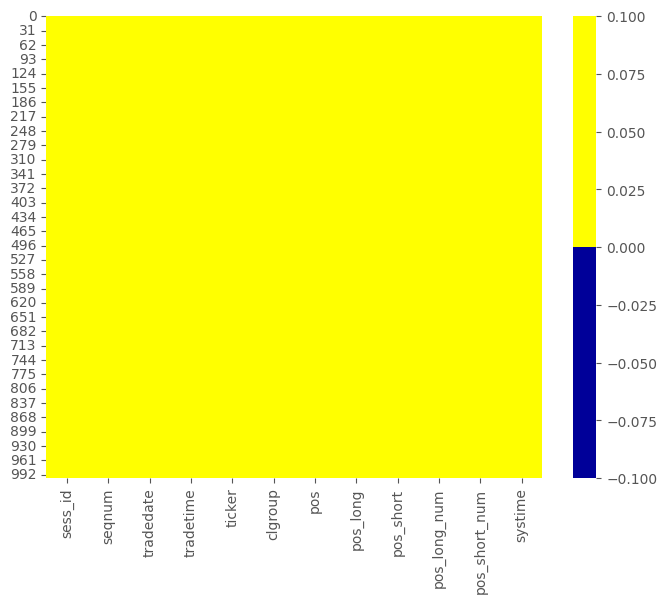

In [65]:
cols = df.columns[:1000] # первые 1000 колонок
# определяем цвета
# желтый - пропущенные данные, синий - не пропущенные
colours = ['#000099', '#ffff00']
sns.heatmap(df[cols].isnull(), cmap=sns.color_palette(colours))

В нашем случае никаких пропущенных данных нет, значит эту статистику можно пропустить

### Аномальные значения
Для поиска аномальных значений будем использовать boxplot-график и описательную статистику (квартили распределения)

***Есть ещё кластеризация и z-оценки, надо решить, будем ли их использовать***

<Axes: >

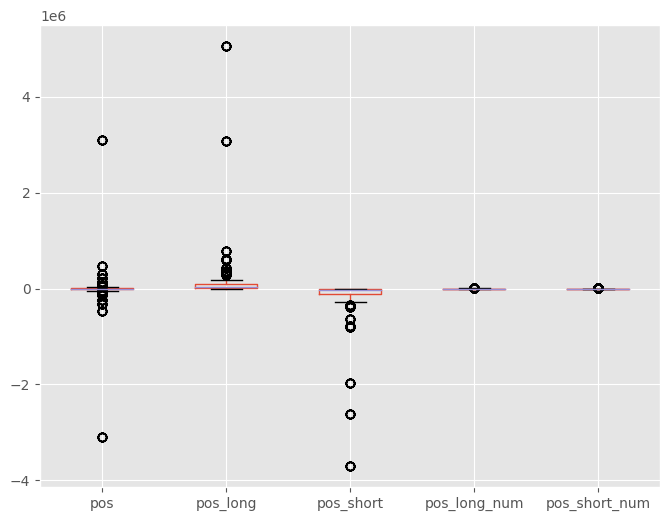

In [66]:
df.boxplot(column=['pos', 'pos_long', 'pos_short', 'pos_long_num', 'pos_short_num'])

In [67]:
df[['pos', 'pos_long', 'pos_short', 'pos_long_num', 'pos_short_num']].describe()

,pos,pos_long,pos_short,pos_long_num,pos_short_num
count,1.000000e+03,1.000000e+03,1.000000e+03,1000.000000,1000.000000
mean,2.212600e+01,2.007265e+05,-2.007044e+05,1157.440000,915.810000
std,5.284036e+05,6.945461e+05,5.785303e+05,2358.450294,2351.789508
min,-3.087840e+06,5.000000e+00,-3.702084e+06,1.000000,2.000000
25%,-1.016925e+04,6.879000e+03,-1.200148e+05,18.000000,21.000000
50%,0.000000e+00,2.264800e+04,-2.335300e+04,212.500000,64.000000
75%,1.176000e+04,1.010652e+05,-5.564000e+03,1092.000000,517.500000
max,3.087840e+06,5.053721e+06,-1.000000e+01,13201.000000,16669.000000


Видно, что у нас есть явные выбросы по pos_long_num и pos_short_num.

### Неинформативные признаки
Будем откидывать признаки, у которых больше 95% одинаковых значений

In [68]:
num_rows = len(df.index)
low_information_cols = []

for col in df.columns:
    cnts = df[col].value_counts(dropna=False)
    top_pct = (cnts/num_rows).iloc[0]

    if top_pct > 0.95:
        low_information_cols.append(col)
        print('{0}: {1:.5f}%'.format(col, top_pct*100))
        print(cnts)
        print()

sess_id: 100.00000%
6911    1000
Name: sess_id, dtype: int64

tradedate: 100.00000%
2023-10-20    1000
Name: tradedate, dtype: int64



In [74]:
# Откидываем их
df.drop(['sess_id', 'tradedate'], axis=1)

,seqnum,tradetime,ticker,clgroup,pos,pos_long,pos_short,pos_long_num,pos_short_num,systime
0,58,23:50:00,USDRUBF,YUR,1175,115746,-114571,48,25,2023-10-20 23:50:06
1,58,23:50:00,YN,FIZ,16004,23008,-7004,1360,272,2023-10-20 23:50:06
2,58,23:50:00,AF,FIZ,-370,9218,-9588,298,215,2023-10-20 23:50:06
3,58,23:50:00,SF,FIZ,-228772,48654,-277426,1999,4318,2023-10-20 23:50:06
4,58,23:50:00,MX,FIZ,-16509,29206,-45715,1093,2844,2023-10-20 23:50:06
...,...,...,...,...,...,...,...,...,...,...
995,45,22:45:00,CR,FIZ,-3087007,614947,-3701954,2537,8654,2023-10-20 22:45:07
996,45,22:45:00,GZ,FIZ,136430,170857,-34427,5231,1609,2023-10-20 22:45:07
997,45,22:45:00,AL,FIZ,-11760,27448,-39208,643,418,2023-10-20 22:45:07
998,45,22:45:00,BR,YUR,-65,38682,-38747,70,46,2023-10-20 22:45:07


### Отбрасываем повторяющиеся записи

***Надо обговорить, что мы считаем под одинаковыми записями***

```
# отбрасываем неуникальные строки
df_dedupped = df.drop('id', axis=1).drop_duplicates()

# сравниваем формы старого и нового наборов
print(df.shape)
print(df_dedupped.shape)
```




### Приводим всё к верхним регистрам

In [78]:
df['ticker'] = df['ticker'].str.upper()
df['clgroup'] = df['clgroup'].str.upper()
df[['ticker', 'clgroup']].value_counts(dropna=False)

ticker   clgroup
AF       FIZ        14
SF       FIZ        14
AF       YUR        14
MX       FIZ        14
         YUR        14
                    ..
CNYRUBF  FIZ        13
         YUR        13
SN       YUR        13
         FIZ        13
YN       YUR        13
Length: 72, dtype: int64

# Через JSON

In [ ]:
# Ссылка на данные
url = "https://iss.moex.com/iss/analyticalproducts/futoi/securities.json"

In [35]:
# Отправляем GET-запрос по указанной ссылке
response = rq.get(url)

# Проверяем статус ответа
if response.status_code == 200:
    # Загружаем данные из ответа в переменную data в случае успеха
    data = response.json()
else:
    print("Ошибка при получении данных")

In [ ]:
print(json.dumps(data))